# Emotion Classification Using Stacking Classifier with Multiple Base Models

In this Colab notebook, we implement a **Stacking Classifier** for emotion classification using a balanced, augmented dataset. The stacking approach combines multiple base classifiers to improve predictive performance by leveraging the strengths of each model.

### Key Highlights:
1. **Dataset Splitting:**
   - The dataset is divided into **training** (60%), **validation** (20%), and **testing** (20%) subsets.
   - Training data is used for model optimization, validation data for interim evaluation, and test data for final assessment.

2. **Text Vectorization:**
   - Text data is transformed into numerical features using **TF-IDF Vectorizer**, enabling machine learning models to process textual data effectively.

3. **Stacking Classifier:**
   - The stacking classifier combines predictions from four base classifiers:
     - **Logistic Regression**
     - **Naive Bayes**
     - **Decision Tree**
     - **Random Forest**
   - These base classifiers' outputs are aggregated using a **Logistic Regression** model as the final estimator.

4. **Performance Evaluation:**
   - The stacking model is evaluated on:
     - Training data: To verify learning effectiveness.
     - Validation data: To assess generalization capability.
     - Test data: To measure performance on unseen examples.

5. **Model Saving:**
   - The trained stacking model and the TF-IDF vectorizer are saved for later use.

6. **Confusion Matrix Analysis:**
   - A confusion matrix visualizes the model's predictions on the test set, providing insights into its classification strengths and weaknesses.

This notebook demonstrates the application of ensemble learning techniques to emotion classification, showcasing how stacking improves predictive performance by leveraging multiple models.


# Step 1: Import Libraries

In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Step 2: Load the combined dataset

In [2]:
# Load the augmented dataset
df = pd.read_csv('Augmented_Emotion_Dataset.csv')

# Split the dataset into features and labels
X = df['cleaned_text']
y = df['EMOTION']

# Step 3: Split the Data into Train and Test Sets

In [3]:
# Split into train, validation, and test sets (60%-20%-20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [4]:
X_train.shape, X_val.shape, X_test.shape

((141904,), (47301,), (47302,))

# Step 4: Text Vectorization using TF-IDF

In [5]:
# Vectorize the text data using TF-IDF
tfidf = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

# Step 5: Train and Evaluate Stacking Classifier using the augmented balanced dataset

Model saved successfully with joblib.
TF-IDF vectorizer saved as 'tfidf_vectorizer.pkl'.

--- Training Performance ---
Training Accuracy: 0.9900
Training Classification Report:
               precision    recall  f1-score   support

       anger       0.99      0.99      0.99     12530
     boredom       1.00      1.00      1.00      9899
   confusion       0.99      0.99      0.99     12650
     disgust       1.00      1.00      1.00     13763
        fear       0.99      0.99      0.99     13012
       guilt       0.99      0.99      0.99     13678
         joy       0.98      0.97      0.97     16533
     neutral       0.99      0.99      0.99     12356
     sadness       0.99      0.99      0.99     14313
       shame       0.98      1.00      0.99     12923
    surprise       1.00      1.00      1.00     10247

    accuracy                           0.99    141904
   macro avg       0.99      0.99      0.99    141904
weighted avg       0.99      0.99      0.99    141904


--- Vali

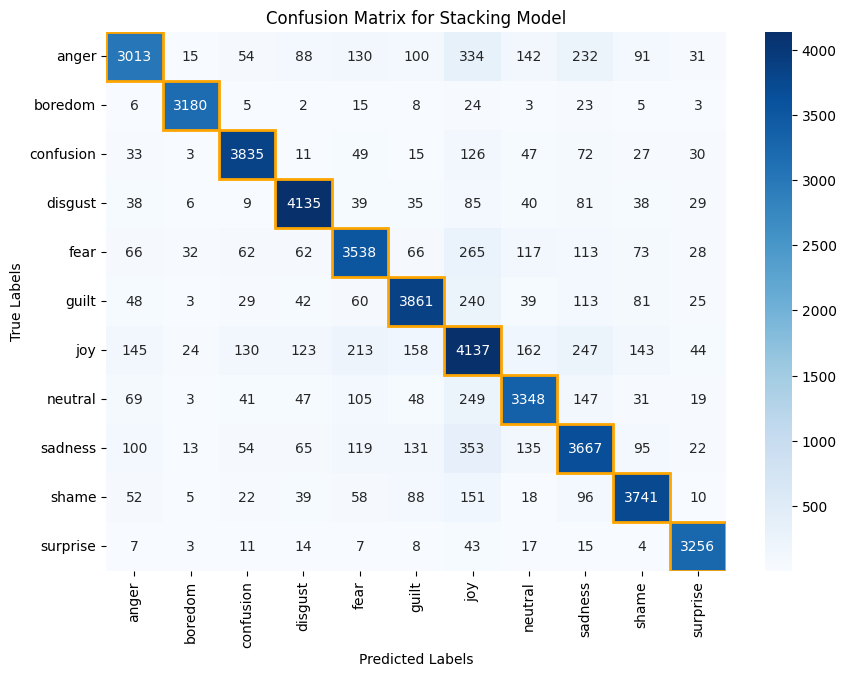

In [6]:
# Define base models for stacking
base_models = [
    ('log_reg', LogisticRegression(max_iter=1000)),
    ('naive_bayes', MultinomialNB()),
    ('decision_tree', DecisionTreeClassifier(random_state=42)),
    ('random_forest', RandomForestClassifier(random_state=42))
]

# Define the stacking classifier
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(max_iter=1000),
    stack_method='predict_proba',
    n_jobs=-1  # Use all available processors
)

# Train the stacking model
stacking_model.fit(X_train_tfidf, y_train)

# Save the stacking model as a pickle file
from joblib import dump, load
dump(stacking_model, 'stacking_model.joblib')
print("Model saved successfully with joblib.")

# Save the TF-IDF vectorizer
with open('tfidf_vectorizer1.pkl', 'wb') as vectorizer_file:
    pickle.dump(tfidf, vectorizer_file)
print("TF-IDF vectorizer saved as 'tfidf_vectorizer.pkl'.")

# Make predictions with the stacking model
y_pred = stacking_model.predict(X_test_tfidf)

# Evaluate the model on the training set
y_train_pred = stacking_model.predict(X_train_tfidf)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("\n--- Training Performance ---")
print(f"Training Accuracy: {train_accuracy:.4f}")
print("Training Classification Report:\n", classification_report(y_train, y_train_pred))

# Evaluate the model on the validation set
y_val_pred = stacking_model.predict(X_val_tfidf)
val_accuracy = accuracy_score(y_val, y_val_pred)
print("\n--- Validation Performance ---")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print("Validation Classification Report:\n", classification_report(y_val, y_val_pred))

# Evaluate the model on the testing set
y_test_pred = stacking_model.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("\n--- Testing Performance ---")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(" Testing Classification Report:\n", classification_report(y_test, y_test_pred))

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')

    # Highlight the diagonal with a different color
    for i in range(len(cm)):
        plt.gca().add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='orange', lw=2))

    plt.show()

# Plot the confusion matrix for the stacking model
plot_confusion_matrix(y_test, y_test_pred, "Stacking Model", labels=np.unique(y))

In [ ]:
import nltk
nltk.download('stopwords')
import pickle
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

from joblib import load
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Load the saved model
stacking_model = load('stacking_model.joblib')
print("Model loaded successfully.")

# Load the saved TF-IDF vectorizer
tfidf = load('tfidf_vectorizer1.pkl')  # Ensure you saved this earlier during training
print("TF-IDF vectorizer loaded successfully.")

# Preprocessing Function
def preprocess_text(input_text):
    # Convert to lowercase
    text = input_text.lower()

    # Remove special characters
    text = re.sub(r'[^\w\s]', '', text)

    # Remove stopwords
    stop = set(stopwords.words('english'))
    stop.difference_update(['in', 'on'])  # Keep 'in' and 'on' if needed
    text = " ".join(word for word in text.split() if word not in stop)

    # Apply stemming
    st = PorterStemmer()
    text = " ".join(st.stem(word) for word in text.split())

    return text

# Function to Make Predictions
def predict_emotion():
    # User input
    user_input = input("Enter a sentence to classify its emotion: ")

    # Preprocess the input
    cleaned_text = preprocess_text(user_input)

    # Transform input using TF-IDF vectorizer
    text_vector = tfidf.transform([cleaned_text])

    # Predict using the loaded model
    prediction = stacking_model.predict(text_vector)

    # Output the prediction
    print(f"Predicted Emotion: {prediction[0]}")

# Call the prediction function
predict_emotion()



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Model loaded successfully.
TF-IDF vectorizer loaded successfully.
Enter a sentence to classify its emotion: i am so happy
Predicted Emotion: disgust
